# Variational Autoencoder with MNIST

## Setup

VAE with Gaussian Latent Variables and Gaussian Posterior distribution.

Specifications:

* Latent variable $\textbf{z} \sim p (\textbf{z}) = \mathcal N_p ({\bf\mu}, {\bf \Sigma})$, with mean zero and ${\bf \Sigma}$ diagonal
* Decoder $p(\mathbf{x}|\mathbf{z})$ is given by a MLP with a single hidden layer
* Encoder $q_\phi({\bf z}|{\bf x})= \mathcal{N}({\bf z}, \boldsymbol{\mu}({\bf x}), \mathrm{diag}(\boldsymbol{\sigma}^2({\bf x})))$
* Cost-function consisting of a reconstruction error with a regularization, that minimizes the KL-Divergence. The reconstruction error is the crossentropy between samples and their reconstructions.
* KL-Divergence for this setup
$$-D_{KL}(q_\phi({\bf z}|{\bf x})|p({\bf z}))={1 \over 2} \sum_{j=1}^J \left (1+\log{\sigma_j^2({\bf x})}-\mu_j^2({\bf x}) -\sigma_j^2({\bf x})\right).
$$

### The approximation
The intractable $p(\mathbf{x}|\mathbf{z})$ is approximated by $q_\phi({\bf z}|{\bf x})$, c.f. mean field approximation in physics. Further possible approximations are Mises-Fisher, Gaussian Mixtures.

## VAE Class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras import backend as K
from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, Add, Multiply)
from keras.models import Model, Sequential
import pandas as pd

class VariationalAutoencoder:
    def __init__(self, shape):
        self.input_dim = shape['input_dim']
        self.hidden_dim  = shape['hidden_dim']
        self.latent_dim = shape['latent_dim']

    def _encoder(self, epsilon_std):
        X = Input(shape=(self.input_dim,))
        H = Dense(self.hidden_dim, activation='relu')(X)

        mu = Dense(self.latent_dim)(H)
        log_var = Dense(self.latent_dim)(H)

        mu, log_var = KLDivergenceLayer()([mu, log_var])

        sigma = Lambda(lambda t: K.exp(.5*t))(log_var)
        eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(X)[0], self.latent_dim)))
        z_eps = Multiply()([sigma, eps])
        z = Add()([mu, z_eps])
        
        model = Model(inputs=[X, eps], outputs=z)
        self.encoder = model

        return model

    def _decoder(self):
        model = Sequential([
            Dense(self.hidden_dim, input_dim=self.latent_dim, activation='relu'),
            Dense(self.input_dim, activation='sigmoid')
            ])
        self.decoder = model

        return model
  
    def autoencoder(self, epsilon_std):
        enc = self._encoder(epsilon_std)
        dec = self._decoder()

        X = Input(shape=(self.input_dim,))
        eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(X)[0], self.latent_dim)))
        Z = enc([X, eps])
        X_pred = dec(Z)

        self.model = Model(inputs=[X, eps], outputs=X_pred, name='vae')

    def train(self, x_train, x_test, params):
        optimizer = params['optimizer']
        loss = nll
        batch_size = params['batch_size']
        epochs = params['epochs']
        epsilon_std = params['epsilon_std']

        self.autoencoder(epsilon_std)
        self.model.compile(optimizer=optimizer, loss=loss)

        history = self.model.fit(
            x_train,
            x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test)
            )
        return history
        
    def plot_loss(self):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['loss', 'val_loss'], loc='upper left')
        plt.show()

    def sample_plotter(self, n, digit_size):
        z1_u = np.linspace(5, -5, n)
        z2_u = np.linspace(5, -5, n)
        z_grid = np.dstack(np.meshgrid(z1_u, z2_u))

        u_grid = np.dstack(np.meshgrid(np.linspace(0.01, 0.99, n),
                                      np.linspace(0.01, 0.99, n)))
        z_grid = norm.ppf(u_grid)
        x_decoded = self.decoder.predict(z_grid.reshape(n*n, 2))
        x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

        plt.figure(figsize=(10, 10))
        plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
        plt.show()

# Imported from https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/
def nll(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

Using TensorFlow backend.


## Set Parameters & Load Data

In [0]:
from keras.datasets import mnist

%matplotlib inline

shape_parameters = {'input_dim': 784,
                    'hidden_dim': 256,
                    'latent_dim': 2
                    }

fit_parameters = {'optimizer': 'rmsprop', 
                  'batch_size': 100,
                  'epochs': 5,
                  'epsilon_std': 1.0
                  }

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, shape_parameters['input_dim']) / 255.
x_test = x_test.reshape(-1, shape_parameters['input_dim']) / 255.

## Initialize and train VAE

In [3]:
vae = VariationalAutoencoder(shape_parameters)

history = vae.train(x_train, x_test, fit_parameters)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/5





60000/60000 [==============================] - 10s 168us/step - loss: 189.4318 - val_loss: 172.9038
Epoch 2/5
60000/60000 [==============================] - 10s 164us/step - loss: 170.0272 - val_loss: 168.0674
Epoch 3/5
60000/60000 [==============================] - 10s 163us/step - loss: 166.9895 - val_loss: 167.2254
Epoch 4/5
60000/60000 [==============================] - 10s 163us/step - loss: 165.2695 - val_loss: 164.5643
Epoch 5/5
60000/60000 [==============================] - 10s 164us/step - loss: 164.3644 - val_loss: 163.3795


## Plot Samples

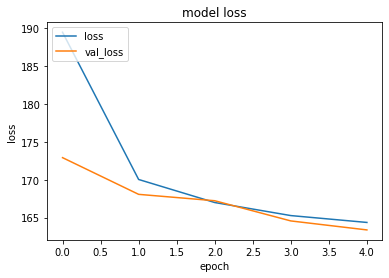

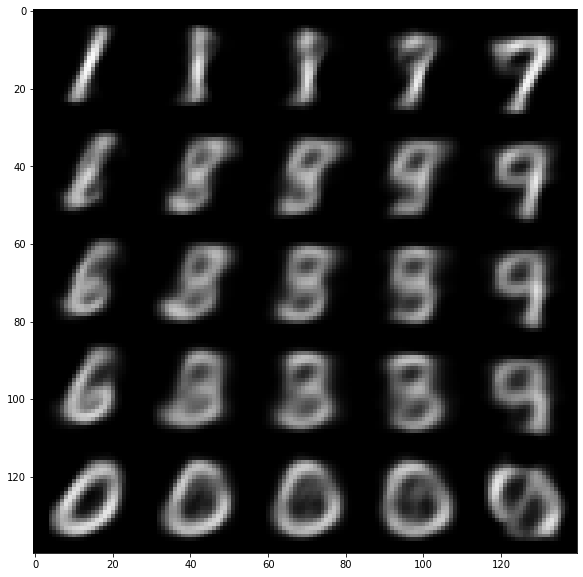

In [4]:
vae.plot_loss()

n = 5
digit_size = 28

vae.sample_plotter(n, digit_size)

## Plot embedding in hidden variable space

In [0]:
#